# Hybrid Search with LangChain and Pinecone using Reciprocal Rank Fusion
* Notebook by Adam Lang
* Date: 11/22/24

# Why is “Semantic” Search NOT all you need?
* At a high level, semantic search is using dense vectors (embeddings) for detecting subtle semantic relations between user queries and sentences
  * For example, the semantic relation between “cat chases mouse” and “kitten hunts mouse” is stronger than between “cat chases mouse” and “I like to eat ham”.
  * Using dense vectors (embeddings) we can easily identify the text with the highest relevance using similarity metrics such as cosine similarity
* In addition to complex semantic text searches, dense vector retrieval offers numerous advantages:
  * **Understanding similar semantics**
    * exemplified by mouse/mousetrap/cheese or Google/Bing/search engine comparisons
  * **Providing multilingual comprehension**
    * enables cross-language understanding, such as matching English input with Chinese content and vice versa
  * **Supporting multimodal comprehension**
    * allows for similar matching across text, images, audio, and video
  * **Offering fault tolerance**
    * efficiently handling spelling errors and vague descriptions

**However, dense vector retrieval very often performs poorly in certain scenarios, for example:**
* Searching for specific names of people or objects, like Elon Musk or iPhone 15
* Searching for acronyms, abbreviations, or short phrases, such as RAG, RLHF, ML, DNN
* Searching for IDs, for example, gpt-3.5-turbo or Qwen-2.5-14B-Instruct

**These limitations are where traditional keyword search excels, for example:**
  * **Precise matching**
    * including product names, personal names, product codes, abbreviations, acronyms
  * **Matching with just a few characters**
    * this is a situation where vector search significantly struggles but is also very common among users
  * **Matching low-frequency vocabulary**
    * these words often hold significant meaning
    * for example in the phrase: “Would you like to have coffee with me?”, words like “have” and “coffee” are more meaningful than “you” and “me”.

In most text search scenarios, the main objective is ensuring the most relevant results appear in the candidate list.

Both vector and keyword searches have their strengths in retrieval.
  * Hybrid search merges these two techniques, balancing out their individual weaknesses.


# What is Hybrid Search?
* Hybrid search is combining the 2 search techniques:
  * 1) Semantic Search
    * Dense vector search or “similarity search”.
    * Hallmark of this algorithm is a Dense Matrix.
  * 2) Keyword or Syntactic Search
    * Sparse vector search or “exact search”.
    * Hallmark of this algorithm is a Sparse Matrix.

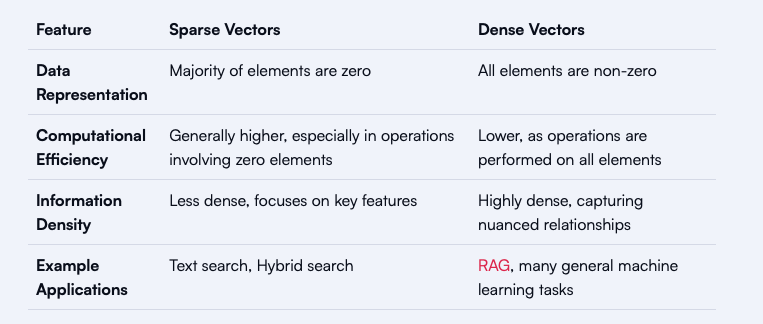




# How does Hybrid Search Work?
* User makes a query.
* We encode the user query using:
  * 1) Sparse Matrix (TF-IDF, BOW, SPLADE)
  * 2) Dense Matrix (Embeddings)
* We search the documents in a database or other vector store (e.g. vector database)
  * We can perform both:
    * 1) Dense vector search (Semantic search)
    * 2) Sparse vector search (Keyword search)
* We retrieve results from BOTH searches.
* We then use a weighting algorithm called “Reciprocal Rank Fusion” to re-rank and concatenate the results so that based on the user query we can deliver the `Top-k` results to the user.
  * If the query is predominantly based on a keyword then we leverage that.
  * If the query is predominantly based on semantics then we leverage that. '
  * If the query is a combination of the two then we can use the power of both to achieve a near 100% result accuracy (hopefully).

# How do we weight Keyword vs. Semantic Search? (Reciprocal Rank Fusion)
* We use an algorithm called Reciprocal Rank Fusion.
* First we perform 2 levels of search:
  * 1) Semantic Search with dense embeddings via Cosine Similarity
  * 2) Keyword Search
* Calculate Final Weighted Score using Reciprocal Rank Fusion:
  * `Final score = Σ 1 / (c+Rd)`
    * c is a constant that is dependent on various databases
      * Can range from `1 to x`
    * `Σ 1 / (Rd)`
      * This means we take the sum of 1 divided by Rank of each document weight.
  * To get the final Rank Score:
    * We calculate the sum rank of each document weight such as this:
      * `[Document 1] = 1 + 0.2 = 1.2`    --> This means that Document 1 is ranked first
      * `[Document 2] = 0.5 + 0.33 = 0.83`
      * `[Document 3] = 0.33 + 0.5 = 0.83`
  * This is based off a configurable weight of 0.5 or 50% keyword search and 50% semantic search.
If you change these weights you obviously will return different results (documents or messages or text).

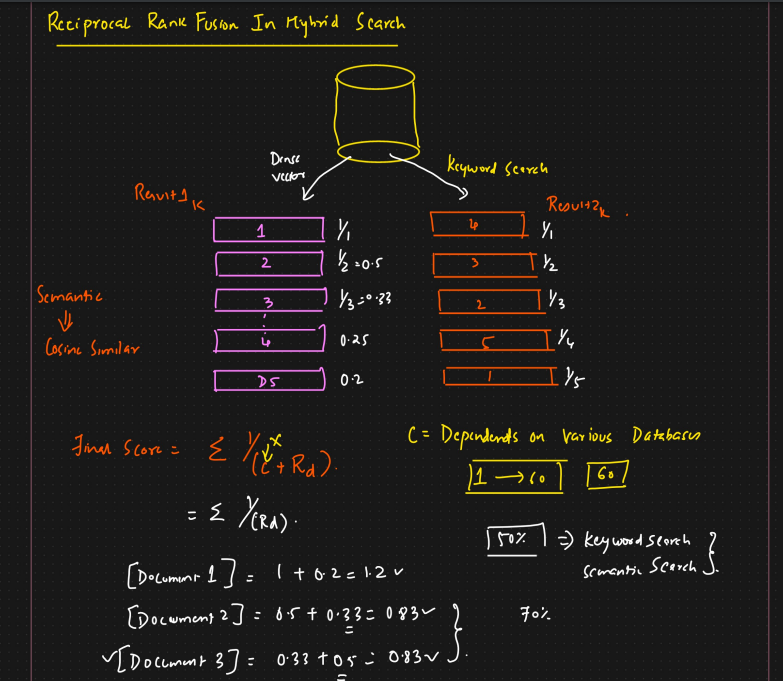

Source: Krish Naik - Udemy
* The concept of Hybrid Search with Reciprocal Rank Fusion
* This calculations above assume we weight 50% for keyword and 50% for semantic search.
* If we increase the weight for Keyword search it will return different results.


# Implementing Hybrid Search in LangChain
* Note: need to run a `requirements.txt` file as there are a lot of requirements

In [1]:
## install libraries
!pip install --upgrade --quiet pinecone-client pinecone-text pinecone-notebooks

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.8/244.8 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.6/67.6 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 kB 4.6 MB/s eta 0:00:00


In [2]:
# pinecone api key
from getpass import getpass

PINECONE_API_KEY = getpass("Enter your pinecone API key: ")

Enter your pinecone API key: ··········


In [3]:
## setup environment
import os

os.environ['PINECONE_API_KEY'] = PINECONE_API_KEY

## Write requirements.txt file
* We need to write the requirements.txt file.
* Then we will run `!pip install -r requirements.txt`

In [4]:
%%writefile requirements.txt
langchain
python-dotenv
ipykernel
langchain-community
pypdf
bs4
arxiv
pymupdf
wikipedia
langchain-text-splitters
langchain-openai
chromadb
sentence_transformers
langchain_huggingface
faiss-cpu
langchain_chroma
duckdb
pandas
openai
langchain-groq
duckduckgo_search==5.3.1b1
pymupdf
arxiv
wikipedia
mysql-connector-python
SQLAlchemy
validators==0.28.1
youtube_transcript_api
unstructured
pytube
numexpr
huggingface_hub

Writing requirements.txt


In [5]:
## install
!pip install -r "/content/requirements.txt"

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 5.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 30.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 60.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 kB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.8/19.8 MB 71.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 617.9/617.9 kB 39.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 64.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.5/27.5 MB 59.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━

In [6]:
## imports
from langchain_community.retrievers import PineconeHybridSearchRetriever #hybrid retriever


# Create Index in Pinecone Vector Database

In [7]:
import os
from pinecone import Pinecone, ServerlessSpec
#create index name
index_name="hybrid-search-langchain-pinecone"

## initialize pinecone client
pc = Pinecone(api_key=PINECONE_API_KEY)

# CREATE INDEX
if index_name not in pc.list_indexes().names():
  # create index if not present
  pc.create_index(
      name=index_name,
      dimension=384, #dimension of dense embedding model (SentenceTransformer model)
      metric="dotproduct", ## sparse values supported only for dotproduct
      spec=ServerlessSpec(cloud='aws',
                          region='us-east-1'), ## from pinecone -- free instance
  )

In [8]:
## init index
index=pc.Index(index_name)
index

# Create Embeddings - Dense & Sparse
* Here we have to create:
  1. Dense vector embedding for the semantic search
    * Dense embedding model card from HF: https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2
  2. Sparse matrix for the keyword search

In [19]:
## enter HF TOKEN
#HF_TOKEN = getpass("Enter your HF Token: ")

Enter your HF Token: ··········


## Setup Dense Embeddings

In [10]:
## vector embedding and sparse matrix
import os
from dotenv import load_dotenv
load_dotenv()

## load HF token
#os.environ['HF_TOKEN'] = HF_TOKEN

## open source embeddings from huggingface
from langchain_huggingface import HuggingFaceEmbeddings

# setup dense vector embeddings
embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2",show_progress=True)
embeddings

HuggingFaceEmbeddings(model_name='all-MiniLM-L6-v2', cache_folder=None, model_kwargs={}, encode_kwargs={}, multi_process=False, show_progress=True)

## Setup Sparse Embeddings
* For this we will use the pinecone `BM25Encoder`
* pinecone docs for BM25 algorithm: https://docs.pinecone.io/guides/data/encode-sparse-vectors

In [13]:
from pinecone_text.sparse import BM25Encoder
import nltk
nltk.download('punkt_tab')


# setup BM25 encoder
bm25_encoder=BM25Encoder().default()
bm25_encoder #load sparse encoder

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


## Test out the Dense and Sparse Encoders

In [27]:
## create dummy data
sentences = [
    "In 2024, I visited London,"
    "In 2022, I visited New York",
    "In 2021, I visited New Orleans",
    "Frankenstein is a great movie",
    "Beauty and the beast movie",
    "Monster.com is a great website",
    "I have to get a CAT scan",
    "My cat is named Elon Musk",
    "GPT-3.5-turbo is worse than Claude-3.5"
]

## applying tfidf values on sentences
bm25_encoder.fit(sentences)

## store values to JSON file
bm25_encoder.dump("bm25_values.json")

## load BM25Encoder object
bm25_encoder = BM25Encoder().load("bm25_values.json")

  0%|          | 0/8 [00:00<?, ?it/s]

Summary:
* We just created a sparse matrix.
* Now we can go create a retriever.

# Create Retriever
* Retriever will utilize both the dense and sparse vectors.

In [22]:
## retriever
retriever = PineconeHybridSearchRetriever(embeddings=embeddings,
                                          sparse_encoder=bm25_encoder,
                                          index=index)

In [23]:
## display retriever
retriever

PineconeHybridSearchRetriever(embeddings=HuggingFaceEmbeddings(model_name='all-MiniLM-L6-v2', cache_folder=None, model_kwargs={}, encode_kwargs={}, multi_process=False, show_progress=True), sparse_encoder=<pinecone_text.sparse.bm25_encoder.BM25Encoder object at 0x7bcf384877c0>, index=<pinecone.data.index.Index object at 0x7bd041c30e80>)

In [28]:
## add texts to retriever
retriever.add_texts(sentences
)

  0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

# Hybrid Search Queries

In [18]:
## now we can ask hybrid search queries of the vector db
retriever.invoke("What city did I visit last")

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

[Document(metadata={'score': 0.286889791}, page_content='In 2021, I visited New Orleans'),
 Document(metadata={'score': 0.258281112}, page_content='In 2024, I visited London,In 2022, I visited New York')]

In [19]:
## another query
retriever.invoke("What city did i visit recent")

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

[Document(metadata={'score': 0.277243465}, page_content='In 2021, I visited New Orleans'),
 Document(metadata={'score': 0.234412476}, page_content='In 2024, I visited London,In 2022, I visited New York')]

In [20]:
## another query
retriever.invoke("What city did i visit first")

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

[Document(metadata={'score': 0.25581643}, page_content='In 2021, I visited New Orleans'),
 Document(metadata={'score': 0.219588652}, page_content='In 2024, I visited London,In 2022, I visited New York')]

In [26]:
## another query
retriever.invoke("monster scary")

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

[Document(metadata={'score': 0.242455244}, page_content='Frankenstein is a great movie'),
 Document(metadata={'score': 0.200592309}, page_content='Beauty and the beast movie'),
 Document(metadata={'score': 0.179165915}, page_content='Monster.com is a great website'),
 Document(metadata={'score': 0.05284857}, page_content='In 2021, I visited New Orleans')]

In [29]:
## another query
retriever.invoke("When was the cat")

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

[Document(metadata={'score': 0.494416714}, page_content='I have to get a CAT scan'),
 Document(metadata={'score': 0.450365424}, page_content='My cat is named Elon Musk'),
 Document(metadata={'score': 0.0988165438}, page_content='Beauty and the beast movie'),
 Document(metadata={'score': 0.0760066733}, page_content='In 2024, I visited London,In 2022, I visited New York')]

In [30]:
## another query
retriever.invoke("What LLM is better")

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

[Document(metadata={'score': 0.0782898068}, page_content='GPT-3.5-turbo is worse than Claude-3.5'),
 Document(metadata={'score': 0.0542398766}, page_content='Monster.com is a great website'),
 Document(metadata={'score': 0.0333015174}, page_content='In 2024, I visited London,In 2022, I visited New York'),
 Document(metadata={'score': 0.0235928465}, page_content='In 2021, I visited New Orleans')]